In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import load_dataset
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

c:\ProgramData\Anaconda3\envs\ML-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


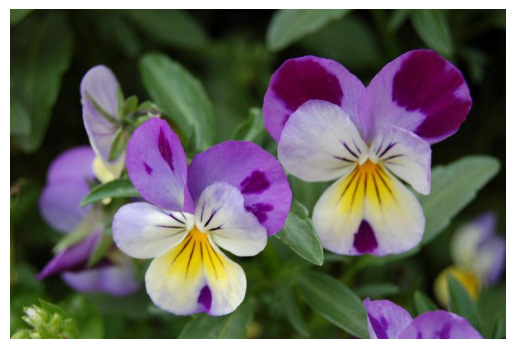

In [2]:
dataset = load_dataset("huggan/flowers-102-categories", split="train[:1000]")

image = dataset[0]['image']
plt.imshow(image)
plt.axis("off")
plt.show()

In [3]:
#Transformations for dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Preprocess images and convert to tensor
def preprocess(data):
    images = [transform(img.convert("RGB")) for img in data['image']]
    return torch.stack(images)

# Load the dataset and apply transformations
train_images = preprocess(dataset[:len(dataset)])


In [4]:
# Define U-Net model for DDPM
model = UNet2DModel(
    sample_size=64,         # 64x64 images
    in_channels=3,          # 3 input channels (RGB)
    out_channels=3,         # 3 output channels (RGB)
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D", "UpBlock2D", "UpBlock2D", "AttnUpBlock2D"
    )
).to(device)





In [5]:

max_timesteps = 10

noise_scheduler = DDPMScheduler(num_train_timesteps=max_timesteps, beta_start=0.0001, beta_end=0.2)

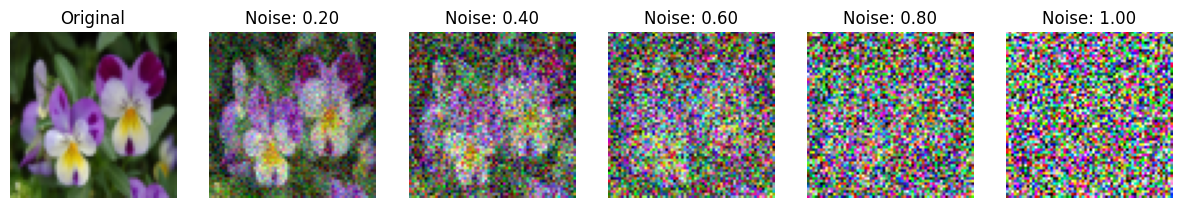

In [6]:

def add_noise(image, noise_level):
    noise = torch.randn_like(image)
    return image * (1 - noise_level) + noise * noise_level

def show_noisy_image(image, num_steps=5):
    fig, axs = plt.subplots(1, num_steps + 1, figsize=(15, 5))
    original_image = image * 0.5 + 0.5
    axs[0].imshow(original_image.permute(1, 2, 0).cpu().detach().numpy().clip(0, 1))
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    # Add noise y
    for i in range(1, num_steps + 1):
        noise_level = i / num_steps
        noisy_image = add_noise(image, noise_level)

        noisy_image = noisy_image * 0.5 + 0.5
        axs[i].imshow(noisy_image.permute(1, 2, 0).cpu().detach().numpy().clip(0, 1))
        axs[i].set_title(f"Noise: {noise_level:.2f}")
        axs[i].axis('off')

    plt.show()

show_noisy_image(train_images[0], num_steps=5)


c:\ProgramData\Anaconda3\envs\ML-env\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


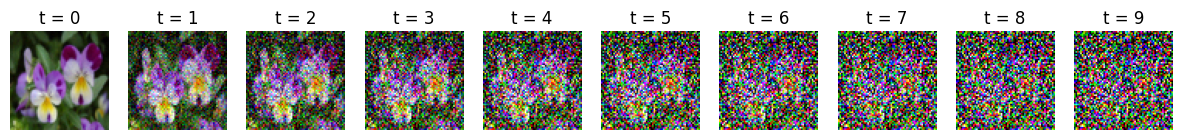

In [7]:
def plot_images(timesteps, noisy_images):
    """
    Plot the noisy images at different timesteps.
    """
    fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 5))
    for i, t in enumerate(timesteps):
        img = noisy_images[i].permute(1, 2, 0).cpu().detach().numpy()  
        img = np.clip(img, 0, 1)  
        axes[i].imshow(img)
        axes[i].set_title(f't = {t}')
        axes[i].axis('off')
    plt.show()


image = train_images[0]  
image = (image * 0.5 + 0.5).to(device)

noise = torch.randn_like(image).to(device)
timesteps = torch.linspace(0, noise_scheduler.num_train_timesteps - 1, steps=max_timesteps).long().to(device)

# Add noise 
noisy_images = []
for t in timesteps:
    noisy_image = noise_scheduler.add_noise(image.unsqueeze(0), noise, t)[0]
    noisy_images.append(noisy_image)


plot_images(timesteps.cpu(), noisy_images)

In [8]:
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

#Set up training loop parameters
epochs = 5
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, shuffle=True)

def train(model, dataloader, scheduler, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for step, batch in enumerate(dataloader):
            batch = batch.to(device)
            noise = torch.randn_like(batch).to(device)
            
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch.shape[0],), device=device).long()
            noisy_images = scheduler.add_noise(batch, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample

            loss = loss_fn(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(dataloader)}], Loss: {loss.item()}")


train(model, train_dataloader, noise_scheduler, optimizer, epochs)



Epoch [0/5], Step [0/125], Loss: 1.1551767587661743
Epoch [0/5], Step [100/125], Loss: 0.25755584239959717
Epoch [1/5], Step [0/125], Loss: 0.3561643064022064
Epoch [1/5], Step [100/125], Loss: 0.23027193546295166
Epoch [2/5], Step [0/125], Loss: 0.2111150324344635
Epoch [2/5], Step [100/125], Loss: 0.11360685527324677
Epoch [3/5], Step [0/125], Loss: 0.40996527671813965
Epoch [3/5], Step [100/125], Loss: 0.19376836717128754
Epoch [4/5], Step [0/125], Loss: 0.30661436915397644
Epoch [4/5], Step [100/125], Loss: 0.14550398290157318


In [9]:
# https://medium.com/@lmpo/mastering-denoising-diffusion-probabilistic-models-8654cb6f6eff 

In [ ]:
# # Function to generate and display input (noise) and output (generated images) after training
# def generate_images_with_input(model, scheduler, num_images=4, num_steps=1000):
#     model.eval()  # Set the model to evaluation mode
#     generated_images = []
#     input_images = []

#     for _ in range(num_images):
#         # Start with random noise (input image)
#         image = torch.randn((1, 3, 64, 64)).to(device)  # Assuming image size is 64x64
#         input_images.append(image.squeeze(0).cpu().detach())  # Store the initial noise

#         # Perform denoising using the scheduler
#         for t in reversed(range(num_steps)):
#             timestep = torch.tensor([t], device=device).long()
#             with torch.no_grad():
#                 noise_pred = model(image, timestep).sample
#             image = scheduler.step(noise_pred, t, image).prev_sample

#         # Detach and store the generated image
#         generated_images.append(image.squeeze(0).cpu().detach())

#     # Visualize the input noise and generated images side by side
#     plot_input_and_generated_images(input_images, generated_images)

# # Function to plot the input (noise) and generated images
# def plot_input_and_generated_images(input_images, generated_images):
#     fig, axes = plt.subplots(2, len(input_images), figsize=(15, 7))
    
#     for i, (input_img, generated_img) in enumerate(zip(input_images, generated_images)):
#         # Plot input image (noise)
#         input_img = (input_img.permute(1, 2, 0) * 0.5 + 0.5).numpy().clip(0, 1)
#         axes[0, i].imshow(input_img)
#         axes[0, i].set_title("Input Noise")
#         axes[0, i].axis('off')
        
#         # Plot generated image (denoised)
#         generated_img = (generated_img.permute(1, 2, 0) * 0.5 + 0.5).numpy().clip(0, 1)
#         axes[1, i].imshow(generated_img)
#         axes[1, i].set_title("Generated Image")
#         axes[1, i].axis('off')

#     plt.show()

# # Call the function to generate and show images along with the input noise
# generate_images_with_input(model, noise_scheduler, num_images=4, num_steps=noise_scheduler.num_train_timesteps)


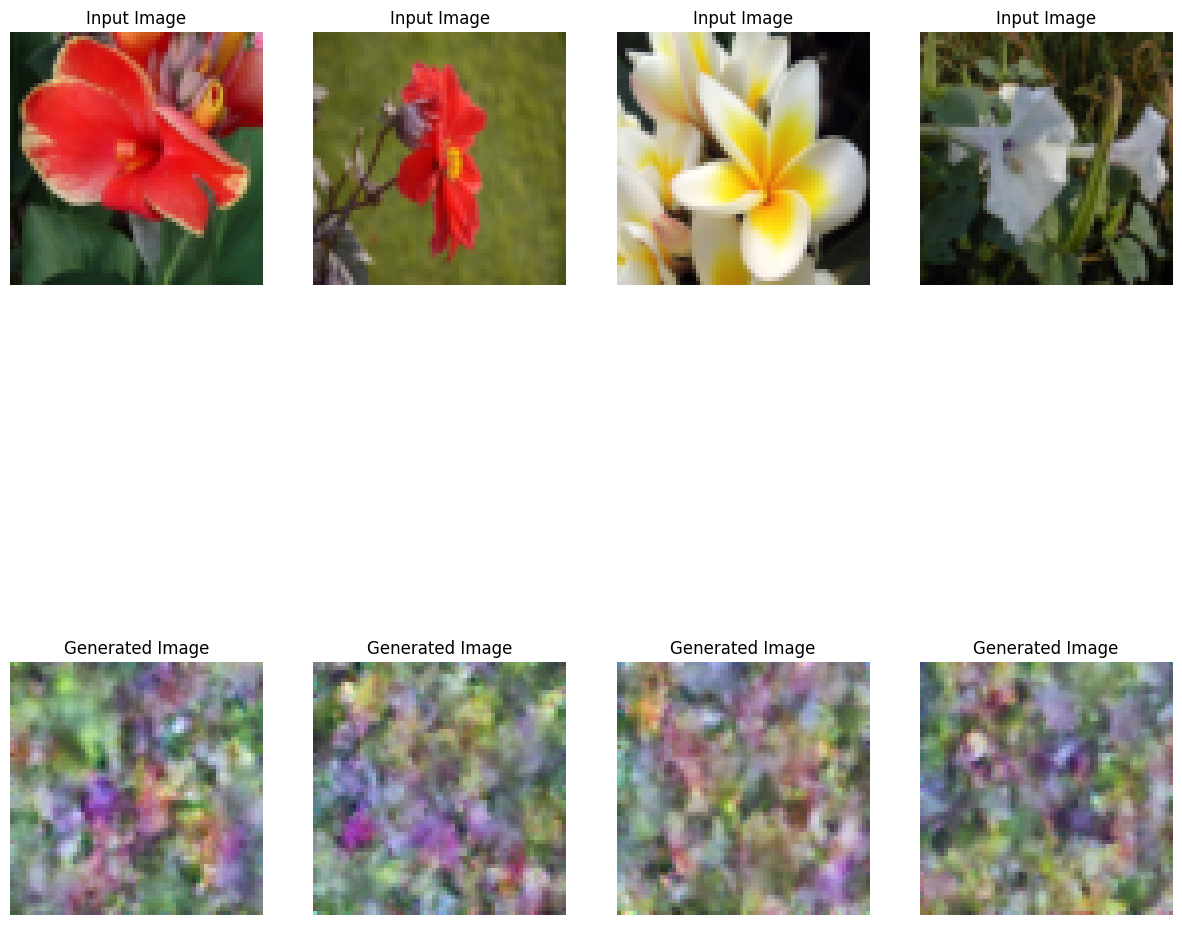

In [14]:

def generate_images_with_input(model, scheduler, input_images, num_images=4, num_steps=1000):
    model.eval()  
    generated_images = []
   
    for _ in range(num_images):
        image = torch.randn((1, 3, 64, 64)).to(device)  

        for t in reversed(range(num_steps)):
            timestep = torch.tensor([t], device=device).long()
            with torch.no_grad():
                noise_pred = model(image, timestep).sample
            image = scheduler.step(noise_pred, t, image).prev_sample
        generated_images.append(image.squeeze(0).cpu().detach()) 

    plot_real_and_generated_images(input_images.cpu(), generated_images)

def plot_real_and_generated_images(real_images, generated_images):
    fig, axes = plt.subplots(2, len(real_images), figsize=(15, 15))
    
    for i, (real_img, generated_img) in enumerate(zip(real_images, generated_images)):
       \
        real_img = (real_img.permute(1, 2, 0).cpu() * 0.5 + 0.5).numpy().clip(0, 1)  
        axes[0, i].imshow(real_img)
        axes[0, i].set_title("Input Image")
        axes[0, i].axis('off')
    
        generated_img = (generated_img.permute(1, 2, 0) * 0.5 + 0.5).numpy().clip(0, 1)
        axes[1, i].imshow(generated_img)
        axes[1, i].set_title("Generated Image")
        axes[1, i].axis('off')

    plt.show()


input_images = next(iter(train_dataloader))[:4] 
input_images = input_images.to(device)  


generate_images_with_input(model, noise_scheduler, input_images, num_images=4, num_steps=10)
